Step-1 Create partial slices of the audio file for continous voice detection
Computes where to split an utterance waveform and its corresponding mel spectrogram to obtain partial utterances of <_n_frames> each. Both the wave form and the mel spectrogram slices are returned, so as to make each partial utterance waver form correspond to its spectrogram.

In [12]:
! pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org umap librosa webrtcvad importlib matplotlib opencv-python keras

In [2]:
#Import Libraries
from scipy.ndimage.morphology import binary_dilation
from pathlib import Path
from typing import Optional, Union
import numpy as np
import webrtcvad
import librosa
import struct
import importlib
importlib.import_module('mpl_toolkits').__path__

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.animation import FuncAnimation
from matplotlib import cm
from time import sleep, perf_counter as timer
# from umap import UMAP
from sys import stderr
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

C:\Users\megha\AppData\Local\Temp\ipykernel_13424\1813348207.py:2: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation
C:\Users\megha\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


#Wav Slicing and Data Preparation

In [3]:
#preprocess wav file
int16_max = (2 ** 15) - 1
vad_window_length = 30  # In milliseconds
# Number of frames to average together when performing the moving average smoothing.
# The larger this value, the larger the VAD variations must be to not get smoothed out. 
vad_moving_average_width = 8
# Maximum number of consecutive silent frames a segment can have.
vad_max_silence_length = 6


## Audio volume normalization
audio_norm_target_dBFS = -30

#Audio
sampling_rate = 16000
#Number of spectrogram frames in a partial utterance
partials_n_frames = 160 # 1600 ms

#MelSpectrogram
mel_window_length = 25
mel_window_step = 10
mel_n_channels = 40

def preprocess_wav(fpath_or_wav: Union[str, Path, np.ndarray], source_sr: Optional[int]=None):
    """
    Applies preprocessing operations to a waveform either on disk or in memory such that  
    The waveform will be resampled to match the data hyperparameters.
    :param fpath_or_wav: either a filepath to an audio file (many extensions are supported, not 
    just .wav), either the waveform as a numpy array of floats.
    :param source_sr: if passing an audio waveform, the sampling rate of the waveform before 
    preprocessing. After preprocessing, the waveform'speaker sampling rate will match the data 
    hyperparameters. If passing a filepath, the sampling rate will be automatically detected and 
    this argument will be ignored.
    """
    # Load the wav from disk if needed
    if isinstance(fpath_or_wav, str) or isinstance(fpath_or_wav, Path):
        wav, source_sr = librosa.load(str(fpath_or_wav), sr=None)
    else:
        wav = fpath_or_wav
    
    # Resample the wav
    if source_sr is not None:
        wav = librosa.resample(wav, orig_sr=source_sr, target_sr=sampling_rate)
        
    # Apply the preprocessing: normalize volume and shorten long silences 
    wav = normalize_volume(wav, audio_norm_target_dBFS, increase_only=True)
    wav = trim_long_silences(wav)
    
    return wav


def wav_to_mel_spectrogram(wav):
    """
    Derives a mel spectrogram ready to be used by the encoder from a preprocessed audio waveform.
    Note: this not a log-mel spectrogram.
    """
    frames = librosa.feature.melspectrogram(
        y=wav,
        sr=sampling_rate,
        n_fft=int(sampling_rate * mel_window_length / 1000),
        hop_length=int(sampling_rate * mel_window_step / 1000),
        n_mels=mel_n_channels
    )
    return frames.astype(np.float32).T


def trim_long_silences(wav):
    """
    Ensures that segments without voice in the waveform remain no longer than a 
    threshold determined by the VAD parameters in params.py.
    :param wav: the raw waveform as a numpy array of floats 
    :return: the same waveform with silences trimmed away (length <= original wav length)
    """
    # Compute the voice detection window size
    samples_per_window = (vad_window_length * sampling_rate) // 1000
    
    # Trim the end of the audio to have a multiple of the window size
    wav = wav[:len(wav) - (len(wav) % samples_per_window)]
    
    # Convert the float waveform to 16-bit mono PCM
    pcm_wave = struct.pack("%dh" % len(wav), *(np.round(wav * int16_max)).astype(np.int16))
    
    # Perform voice activation detection
    voice_flags = []
    vad = webrtcvad.Vad(mode=3)
    for window_start in range(0, len(wav), samples_per_window):
        window_end = window_start + samples_per_window
        voice_flags.append(vad.is_speech(pcm_wave[window_start * 2:window_end * 2],
                                         sample_rate=sampling_rate))
    voice_flags = np.array(voice_flags)
    
    # Smooth the voice detection with a moving average
    def moving_average(array, width):
        array_padded = np.concatenate((np.zeros((width - 1) // 2), array, np.zeros(width // 2)))
        ret = np.cumsum(array_padded, dtype=float)
        ret[width:] = ret[width:] - ret[:-width]
        return ret[width - 1:] / width
    
    audio_mask = moving_average(voice_flags, vad_moving_average_width)
    audio_mask = np.round(audio_mask).astype(np.bool)
    
    # Dilate the voiced regions
    audio_mask = binary_dilation(audio_mask, np.ones(vad_max_silence_length + 1))
    audio_mask = np.repeat(audio_mask, samples_per_window)
    
    return wav[audio_mask == True]

def normalize_volume(wav, target_dBFS, increase_only=False, decrease_only=False):
    if increase_only and decrease_only:
        raise ValueError("Both increase only and decrease only are set")
    rms = np.sqrt(np.mean((wav * int16_max) ** 2))
    wave_dBFS = 20 * np.log10(rms / int16_max)
    dBFS_change = target_dBFS - wave_dBFS
    if dBFS_change < 0 and increase_only or dBFS_change > 0 and decrease_only:
        return wav
    return wav * (10 ** (dBFS_change / 20))

In [4]:


def compute_partial_slices(n_samples: int, rate, min_coverage):

  assert 0 < min_coverage <= 1

  # Compute how many frames separate two partial utterances
  samples_per_frame = int((sampling_rate * mel_window_step / 1000))
  n_frames = int(np.ceil((n_samples + 1) / samples_per_frame))
  frame_step = int(np.round((sampling_rate / rate) / samples_per_frame))
  assert 0 < frame_step, "The rate is too high"
  assert frame_step <= partials_n_frames, "The rate is too low, it should be %f at least" % \
      (sampling_rate / (samples_per_frame * partials_n_frames))

  # Compute the slices
  wav_slices, mel_slices = [], []
  steps = max(1, n_frames - partials_n_frames + frame_step + 1)
  for i in range(0, steps, frame_step):
      mel_range = np.array([i, i + partials_n_frames])
      wav_range = mel_range * samples_per_frame
      mel_slices.append(slice(*mel_range))
      wav_slices.append(slice(*wav_range))

  # Evaluate whether extra padding is warranted or not
  last_wav_range = wav_slices[-1]
  coverage = (n_samples - last_wav_range.start) / (last_wav_range.stop - last_wav_range.start)
  if coverage < min_coverage and len(mel_slices) > 1:
      mel_slices = mel_slices[:-1]
      wav_slices = wav_slices[:-1]

  return wav_slices, mel_slices



def embed_utterance(wav:np.ndarray, return_partials=False, rate=1.3, min_coverage=0.75):
  #Compute where to split the utterance into partials and padd the wave form with zeros if the partial utterances cover a larger range
  wav_slices, mel_slices = compute_partial_slices(len(wav), rate, min_coverage)
  max_wav_length = wav_slices[-1].stop
  if max_wav_length >= len(wav):
    wav = np.pad(wav, (0, max_wav_length - len(wav)), "constant")

  mel = wav_to_mel_spectrogram(wav)
  mels = np.array([mel[s] for s in mel_slices])

  return mels, wav_slices


In [5]:
file_path = Path("OnlineMonitor","Audio_labelled","source","fold1","1-2.wav")
wav = preprocess_wav(file_path)

# segments = [[0, 5.5], [6.5,12], [17,25]]
# speaker_names = ["Kyle Gass", "Sean Evans", "Jack Black"]
# speaker_wavs = [wav[int(s[0] * sampling_rate):int(s[1] * sampling_rate)] for s in segments]
cont_embeds, wav_splits = embed_utterance(wav, return_partials=True, rate=16)

#Testing Melspectrogram fold1

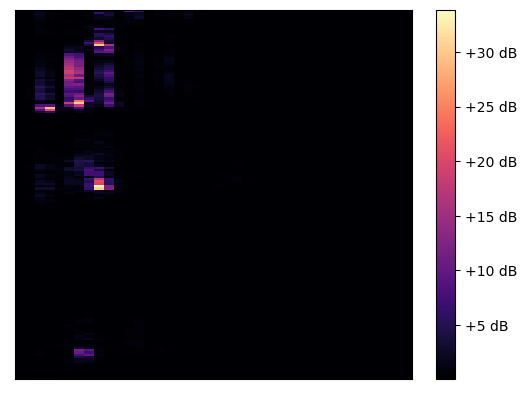

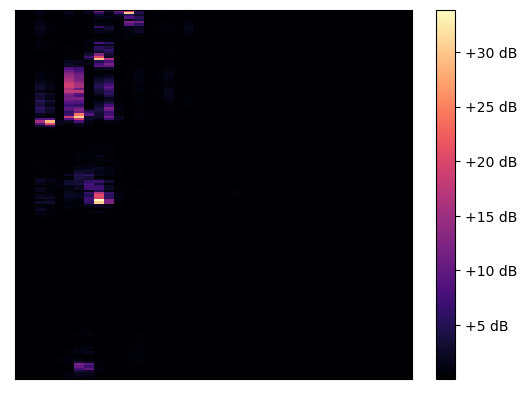

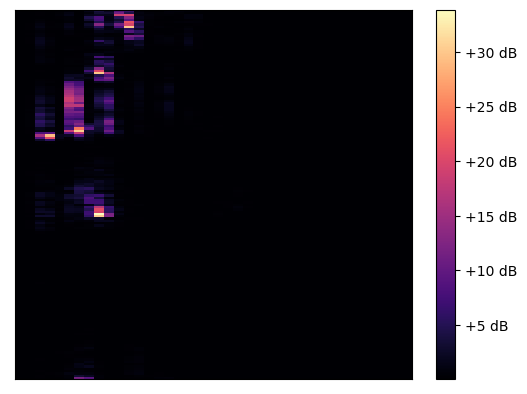

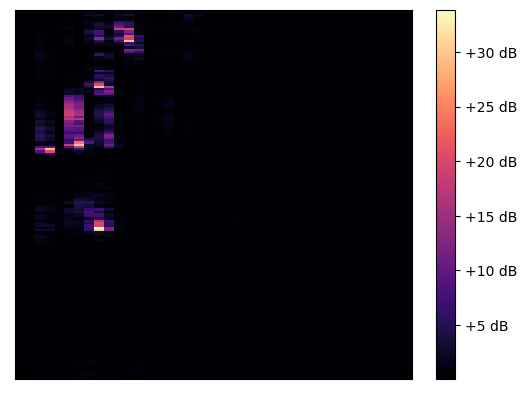

In [6]:
import librosa.display
file_path = Path("OnlineMonitor","Audio_labelled","source","fold1","1-2.wav")
wav = preprocess_wav(file_path)

cont_embeds, wav_splits = embed_utterance(wav, return_partials=True, rate=16)
for i, mel in enumerate(cont_embeds):

  librosa.display.specshow(mel, sr=sampling_rate, hop_length=int((sampling_rate * mel_window_step) / 1000))
  plt.savefig(Path("OnlineMonitor","Audio_labelled","train_images","fold1",str(i)+".png"))
  plt.colorbar(format='%+2.0f dB')
  plt.show()
  if i > 2:
    break

#Testing Melspectrogram fold2

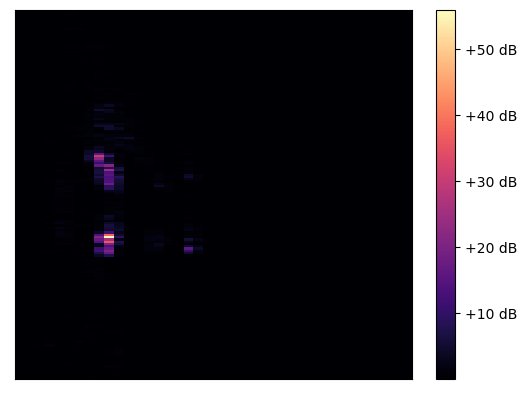

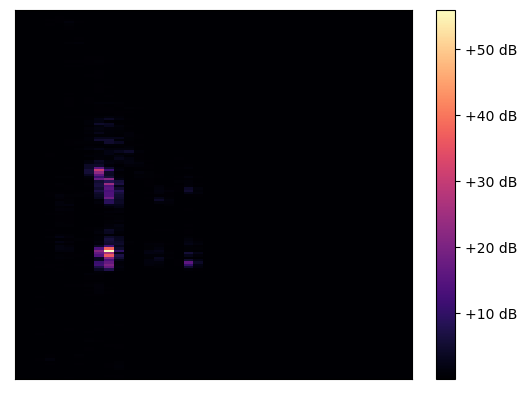

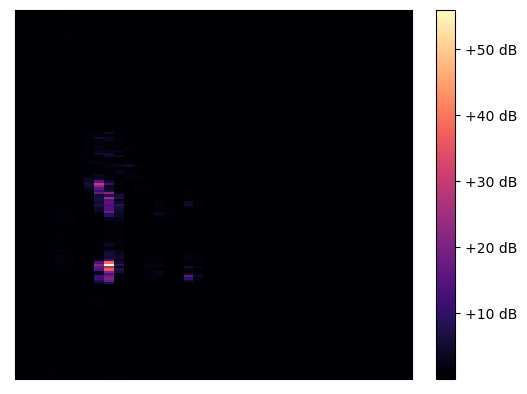

In [7]:
import librosa.display
file_path = Path("OnlineMonitor","Audio_labelled","source","fold2","2-1.wav")
wav = preprocess_wav(file_path)

cont_embeds, wav_splits = embed_utterance(wav, return_partials=True, rate=16)
for i, mel in enumerate(cont_embeds):

  librosa.display.specshow(mel, sr=sampling_rate, hop_length=int(sampling_rate * mel_window_step / 1000))
  plt.savefig(Path("OnlineMonitor","Audio_labelled","train_images","fold2",str(i)+".png"))
  plt.colorbar(format='%+2.0f dB');
  plt.show()
  if i > 1:
    break

#Testing Melspectrogram fold3

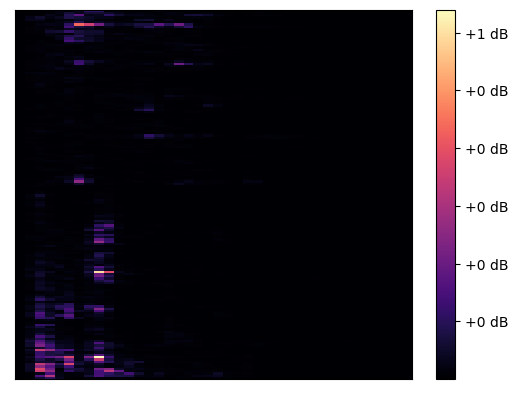

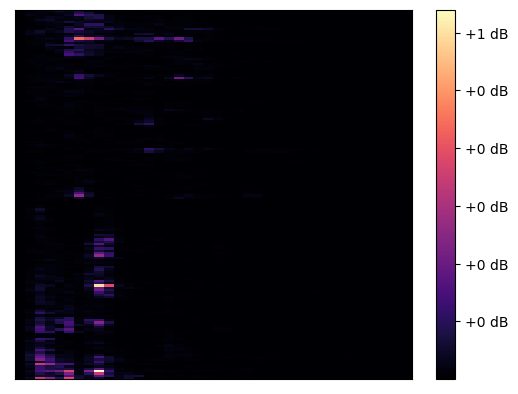

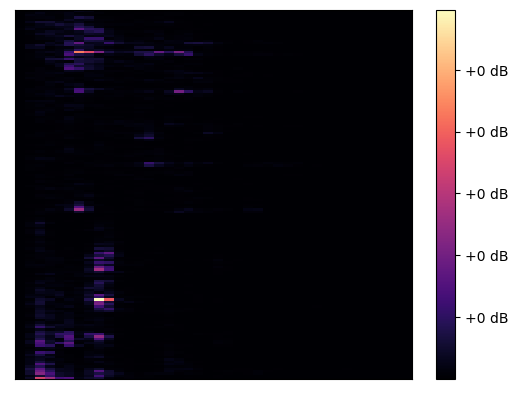

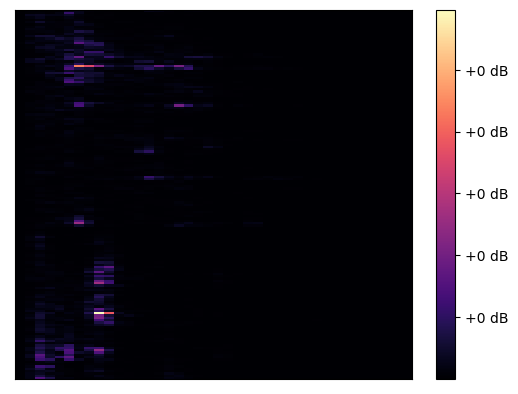

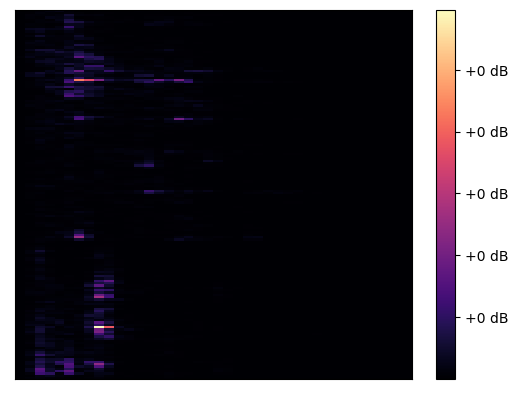

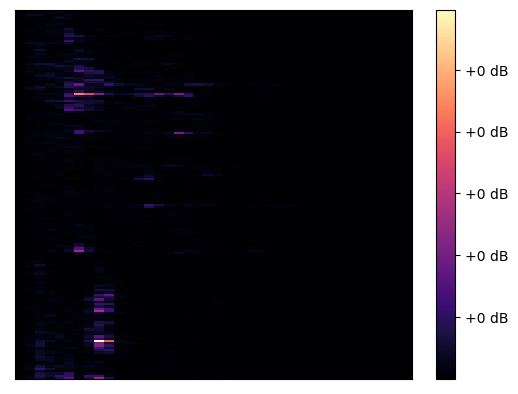

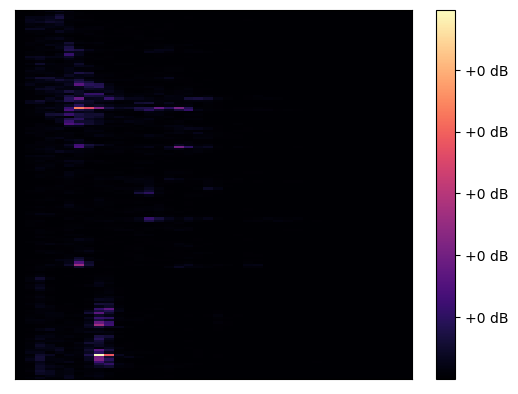

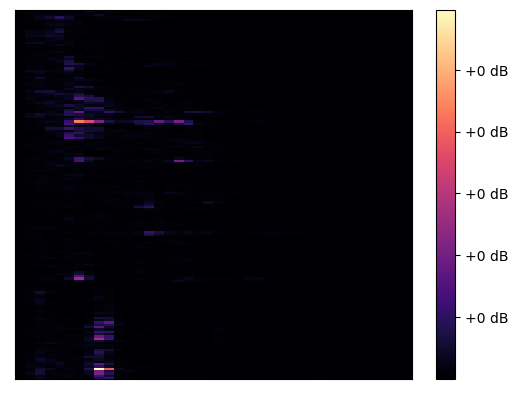

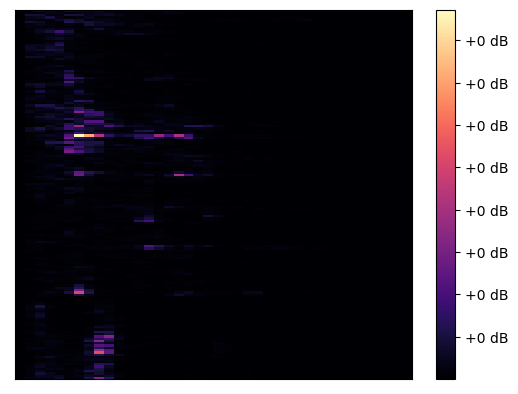

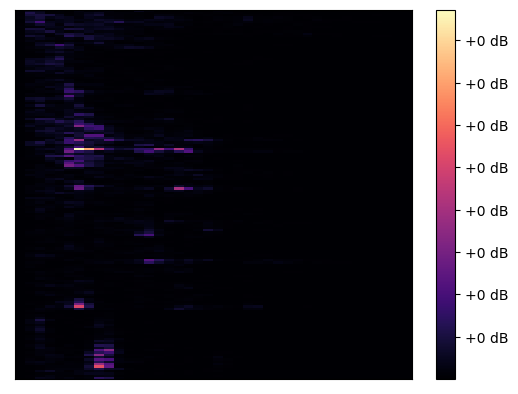

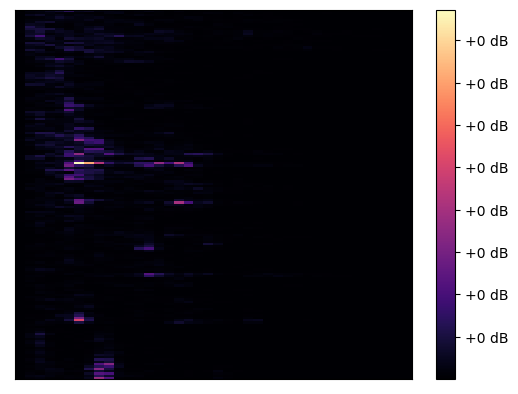

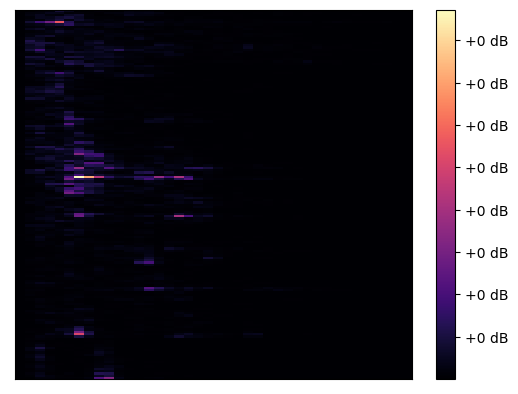

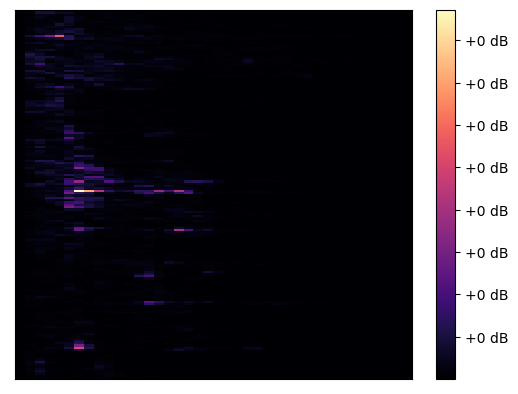

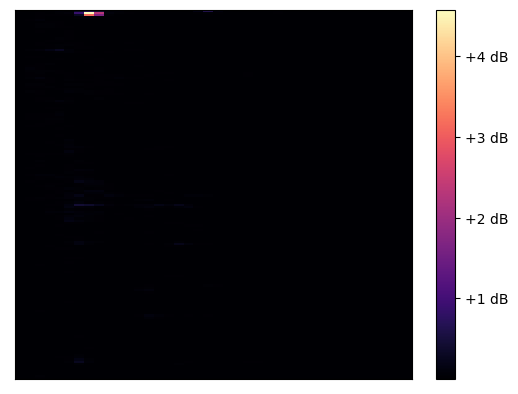

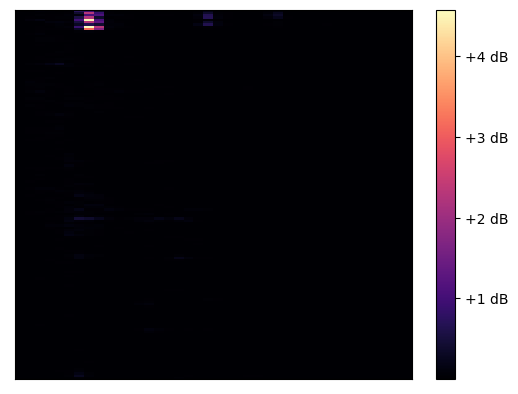

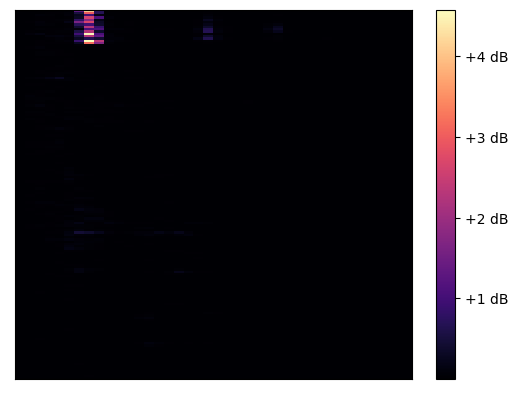

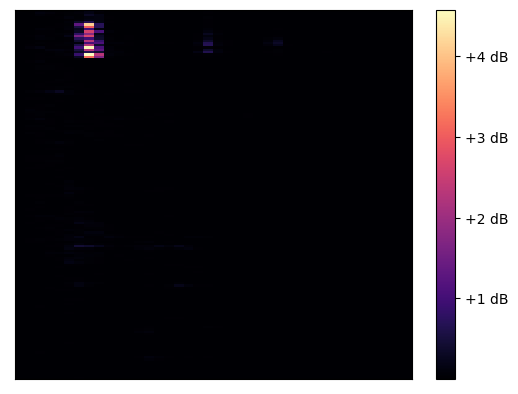

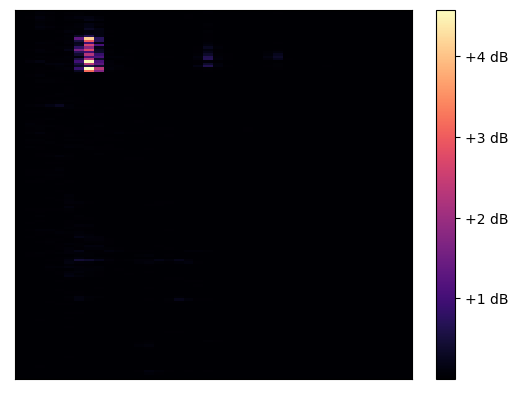

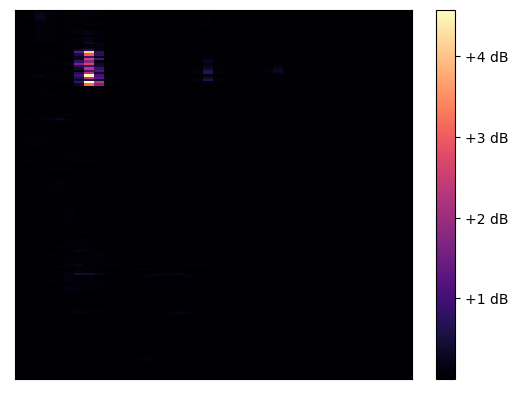

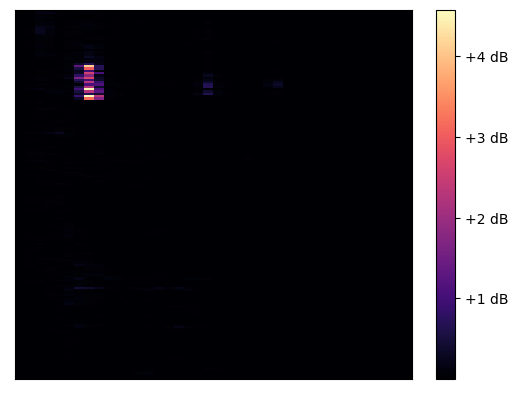

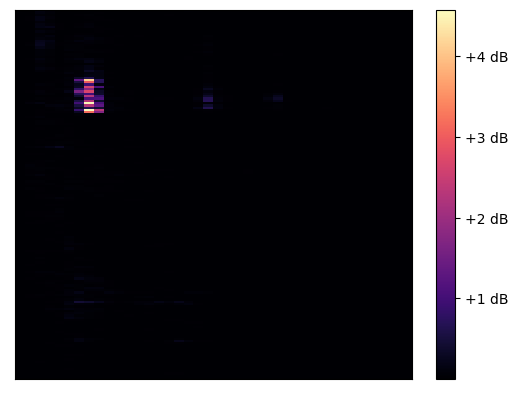

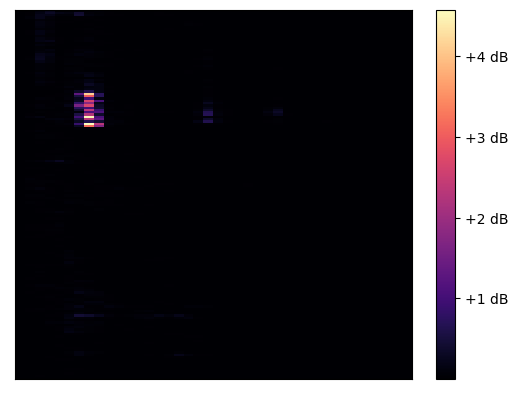

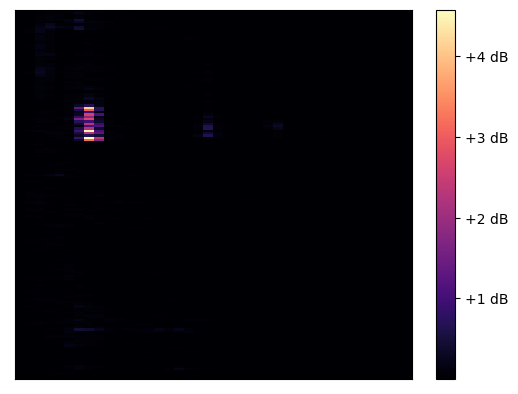

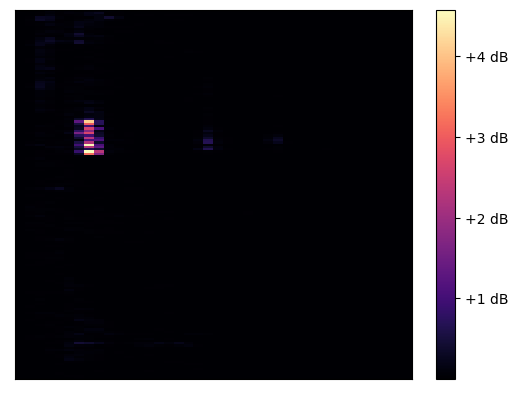

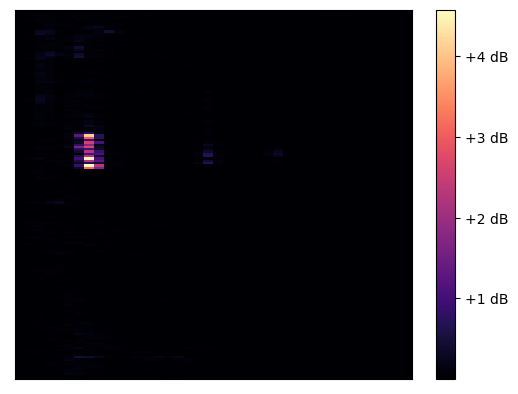

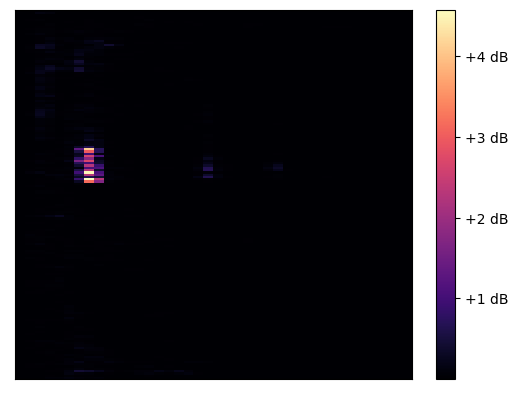

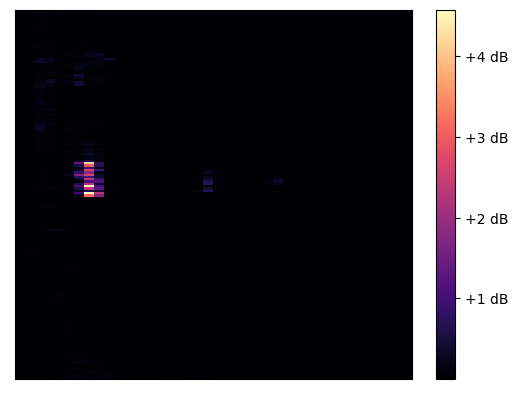

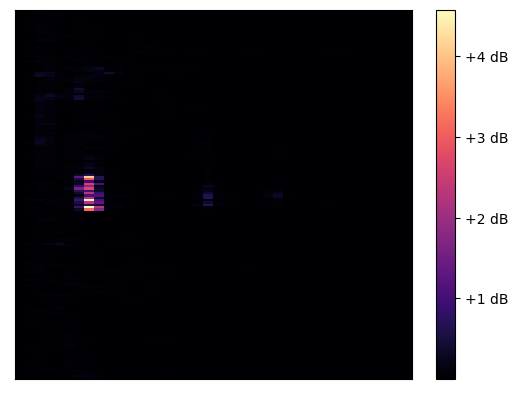

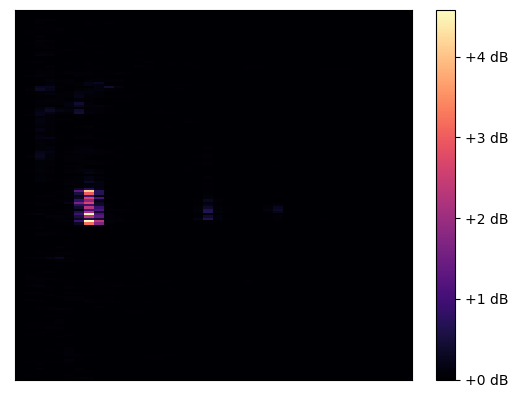

In [8]:
import librosa.display
file_path = Path("OnlineMonitor","Audio_labelled","source","fold3","3-1.wav")
wav = preprocess_wav(file_path)

cont_embeds, wav_splits = embed_utterance(wav, return_partials=True, rate=16)
for i, mel in enumerate(cont_embeds):

  librosa.display.specshow(mel, sr=sampling_rate, hop_length=int(sampling_rate * mel_window_step / 1000));
  plt.savefig(Path("OnlineMonitor","Audio_labelled","train_images","fold3",str(i)+".png"))
  plt.colorbar(format='%+2.0f dB');
  plt.show()


#Save the melspectrogram image for CNN for all files


In [10]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import librosa.display
import os, glob

def wav_to_img(cont_embeds, img_path):
  for i, mel in enumerate(cont_embeds):

    dpi = 80
    magic_height = 300
    w = 192
    h = 192
    #extract audio features

    #Save the melspectrogram 
    fig = plt.Figure()
    fig.set_size_inches(magic_height*w/(h*dpi), magic_height/dpi)
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    #Control the margins 
    left = 0.005
    bottom = 0.005 
    width = 0.99
    height = 0.99
    ax = fig.add_axes([left, bottom, width, height])
    ax.set(frame_on=False)
    p = librosa.display.specshow(mel, sr=sampling_rate, hop_length=int(sampling_rate * mel_window_step / 1000), ax = ax);
    fig.savefig(img_path+"_"+str(i)+".png", dpi = 51.4)

In [13]:
import os, glob

dirs = os.listdir(os.path.join("OnlineMonitor" ,"Audio_labelled","source"))
for dir in dirs:
  print(dir)
  total = 0
  wav_files = glob.glob(os.path.join("OnlineMonitor", "Audio_labelled", "source", dir, "*.wav"))
  for wav_file in tqdm(wav_files):
    wav = preprocess_wav(wav_file)
    cont_embeds, wav_splits = embed_utterance(wav, return_partials=True, rate=16)
    wav_to_img(cont_embeds, os.path.join("OnlineMonitor","Audio_labelled","train_images",dir, str(total)))
    total += 1
    print("{} {}".format(dir, total), end="\r")
    

fold1


  6%|████▍                                                                           | 1/18 [04:05<1:09:26, 245.10s/it]

 11%|████████▉                                                                       | 2/18 [18:58<2:47:07, 626.71s/it]

 17%|█████████████▎                                                                  | 3/18 [20:05<1:32:42, 370.80s/it]

 22%|██████████████████▏                                                               | 4/18 [20:44<56:01, 240.07s/it]

 28%|██████████████████████▏                                                         | 5/18 [26:40<1:01:04, 281.85s/it]

 33%|███████████████████████████▎                                                      | 6/18 [31:03<55:03, 275.33s/it]

 39%|███████████████████████████████▉                                                  | 7/18 [31:43<36:22, 198.39s/it]

 44%|████████████████████████████████████▍                                             | 8/18 [35:12<33:38, 201.88s/it]

 56%|█████████████████████████████████████████████                                    | 10/18 [36:41<15:21, 115.15s/it]

 61%|██████████████████████████████████████████████████                                | 11/18 [36:54<09:46, 83.78s/it]

 67%|██████████████████████████████████████████████████████                           | 12/18 [39:39<10:50, 108.45s/it]

 72%|██████████████████████████████████████████████████████████▌                      | 13/18 [45:22<14:57, 179.50s/it]

 78%|███████████████████████████████████████████████████████████████                  | 14/18 [47:06<10:27, 156.83s/it]

 83%|███████████████████████████████████████████████████████████████████▌             | 15/18 [47:53<06:11, 123.81s/it]

 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [48:08<03:01, 90.98s/it]

 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [48:09<01:03, 63.88s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [48:12<00:00, 160.69s/it]


fold2


  4%|██▉                                                                                | 1/28 [01:33<42:12, 93.81s/it]

  7%|█████▉                                                                             | 2/28 [02:12<26:29, 61.12s/it]

 11%|████████▊                                                                         | 3/28 [04:59<45:39, 109.59s/it]

 14%|███████████▊                                                                       | 4/28 [05:15<29:07, 72.82s/it]

 18%|██████████████▊                                                                    | 5/28 [06:43<29:59, 78.23s/it]

 21%|█████████████████▊                                                                 | 6/28 [07:08<22:00, 60.03s/it]

 25%|████████████████████▊                                                              | 7/28 [07:16<15:05, 43.11s/it]

 32%|██████████████████████████▋                                                        | 9/28 [07:41<08:06, 25.59s/it]

 39%|████████████████████████████████▏                                                 | 11/28 [07:42<03:33, 12.53s/it]

 46%|██████████████████████████████████████                                            | 13/28 [07:43<01:34,  6.31s/it]

 54%|███████████████████████████████████████████▉                                      | 15/28 [07:44<00:43,  3.34s/it]

 61%|█████████████████████████████████████████████████▊                                | 17/28 [07:45<00:20,  1.91s/it]

 64%|████████████████████████████████████████████████████▋                             | 18/28 [07:45<00:13,  1.40s/it]

 68%|███████████████████████████████████████████████████████▋                          | 19/28 [07:46<00:10,  1.20s/it]

 71%|██████████████████████████████████████████████████████████▌                       | 20/28 [08:34<02:01, 15.15s/it]

 75%|█████████████████████████████████████████████████████████████▌                    | 21/28 [08:37<01:20, 11.54s/it]

 82%|███████████████████████████████████████████████████████████████████▎              | 23/28 [08:38<00:29,  5.86s/it]

 86%|██████████████████████████████████████████████████████████████████████▎           | 24/28 [08:38<00:16,  4.18s/it]

 89%|█████████████████████████████████████████████████████████████████████████▏        | 25/28 [08:39<00:09,  3.10s/it]

 93%|████████████████████████████████████████████████████████████████████████████▏     | 26/28 [08:39<00:04,  2.24s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [08:39<00:00,  1.22s/it]

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [08:39<00:00, 18.57s/it]


fold3


  3%|██▊                                                                                | 1/30 [00:02<01:14,  2.57s/it]

  7%|█████▌                                                                             | 2/30 [00:26<07:01, 15.05s/it]

 10%|████████▎                                                                          | 3/30 [00:43<07:10, 15.96s/it]

 13%|███████████                                                                        | 4/30 [01:07<08:20, 19.24s/it]

 17%|█████████████▊                                                                     | 5/30 [01:18<06:45, 16.23s/it]

 20%|████████████████▌                                                                  | 6/30 [01:34<06:23, 16.00s/it]

 23%|███████████████████▎                                                               | 7/30 [01:50<06:09, 16.07s/it]

 27%|██████████████████████▏                                                            | 8/30 [01:53<04:20, 11.85s/it]

 30%|████████████████████████▉                                                          | 9/30 [02:18<05:39, 16.15s/it]

 33%|███████████████████████████▎                                                      | 10/30 [02:30<04:56, 14.80s/it]

 40%|████████████████████████████████▊                                                 | 12/30 [02:32<02:14,  7.49s/it]

 47%|██████████████████████████████████████▎                                           | 14/30 [02:33<01:03,  3.97s/it]

 50%|█████████████████████████████████████████                                         | 15/30 [02:33<00:42,  2.85s/it]

 57%|██████████████████████████████████████████████▍                                   | 17/30 [02:35<00:21,  1.69s/it]

 63%|███████████████████████████████████████████████████▉                              | 19/30 [02:35<00:09,  1.10it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [02:35<00:04,  1.88it/s]

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [02:35<00:03,  2.36it/s]

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [02:39<00:09,  1.34s/it]

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [02:41<00:09,  1.64s/it]

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [02:43<00:05,  1.26s/it]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [02:44<00:02,  1.08it/s]

 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [02:45<00:01,  1.06it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [02:45<00:00,  5.51s/it]

#Load Dataset into variables

In [11]:
import os, random, cv2
from sklearn.preprocessing import LabelBinarizer
dataset=[]
def load_images_from_folder(folder,x):
    image=[]
    im=[]
    c=1
    lower = int(len(os.listdir(folder))*0.70)
    files = os.listdir(folder)
    # files.sort(key=alphaNumOrder)
    files.sort()
    for j, filename in enumerate(files[:1000]):
        try:
            img = cv2.imread(os.path.join(folder,filename))
        except Exception as e:
            
            continue
        n_img=cv2.resize(img,(192,192))
        if img is not None :
            im.append(n_img)
        if c%1==0:
            image.append(im)
            image.append(x)
            im=[]
            dataset.append(image)
            image=[]
        c=c+1
        print(folder,j, end="\r")
    print()
        
load_images_from_folder("OnlineMonitor/Audio_labelled/train_images/fold1","SV")
load_images_from_folder("OnlineMonitor/Audio_labelled/train_images/fold2","MV")
load_images_from_folder("OnlineMonitor/Audio_labelled/train_images/fold3","NV")


x,y=[],[]
random.shuffle(dataset)
for img,lab in dataset:
    x.append(img)
    y.append(lab)
    print(lab)

x = np.array(x)
lb = LabelBinarizer()
lb.fit(y)
y = lb.transform(y)
print( "Label Binarizer:", y.shape)
print("X shape " ,x.shape)
print("Y shape ", y.shape)
x = x.reshape(-1,1,192,192,3)
print("X shape " ,x.shape)
dataset = []

OnlineMonitor/Audio_labelled/train_images/fold1 999
OnlineMonitor/Audio_labelled/train_images/fold2 999
OnlineMonitor/Audio_labelled/train_images/fold3 999
NV
SV
NV
SV
NV
SV
NV
SV
MV
MV
MV
SV
SV
MV
MV
NV
NV
NV
MV
SV
NV
MV
MV
SV
SV
NV
MV
SV
NV
NV
NV
NV
NV
MV
SV
NV
NV
MV
NV
MV
SV
MV
MV
NV
SV
NV
MV
SV
SV
NV
SV
NV
SV
SV
MV
SV
MV
SV
NV
MV
NV
SV
MV
MV
NV
SV
SV
SV
NV
NV
MV
SV
SV
NV
NV
SV
NV
NV
MV
SV
SV
SV
SV
MV
NV
NV
NV
NV
NV
SV
NV
MV
MV
MV
NV
MV
SV
SV
MV
SV
NV
MV
SV
NV
MV
MV
SV
MV
MV
NV
MV
MV
SV
SV
SV
SV
MV
NV
MV
SV
SV
SV
NV
MV
NV
NV
SV
SV
MV
SV
NV
SV
NV
NV
MV
SV
MV
NV
NV
SV
SV
NV
NV
SV
MV
SV
NV
SV
MV
NV
NV
NV
MV
MV
NV
NV
MV
MV
SV
SV
MV
MV
SV
NV
NV
NV
NV
MV
SV
NV
SV
MV
MV
MV
NV
SV
MV
NV
MV
SV
MV
SV
NV
SV
MV
NV
NV
NV
SV
NV
MV
NV
SV
SV
NV
SV
NV
SV
MV
NV
MV
NV
MV
NV
NV
MV
NV
NV
SV
NV
NV
SV
MV
MV
MV
SV
NV
SV
MV
NV
NV
SV
MV
SV
MV
SV
NV
NV
SV
NV
SV
NV
SV
MV
NV
MV
NV
MV
MV
SV
NV
NV
NV
NV
SV
SV
MV
SV
SV
SV
NV
SV
MV
MV
NV
NV
MV
NV
MV
MV
NV
MV
MV
SV
MV
SV
SV
MV
NV
NV
NV
MV
MV
MV
SV
NV
SV
NV
NV
NV
MV
S

Label Binarizer: (3000, 3)
X shape  (3000, 1, 192, 192, 3)
Y shape  (3000, 3)
X shape  (3000, 1, 192, 192, 3)


In [12]:
validset=[]
def load_images_from_folder(folder,x):
    image=[]
    im=[]
    c=1
    lower = 70
    higher = 900
    files = os.listdir(folder)
    # files.sort(key=alphaNumOrder)
    files.sort()
    for j, filename in enumerate(files[1000:1200]):
        try:
            img = cv2.imread(os.path.join(folder,filename))
        except:
            continue
#         img = cv2.imread(os.path.join(folder,filename),cv2.IMREAD_GRAYSCALE)
        n_img=cv2.resize(img,(192,192))
        if img is not None :
            im.append(n_img)
        if c%1==0:          
            image.append(im)
            image.append(x)
            im=[]
            validset.append(image)
            image=[]
        c=c+1   
        print(folder,j, end="\r")
        
load_images_from_folder("OnlineMonitor/Audio_labelled/train_images/fold1","SV")
load_images_from_folder("OnlineMonitor/Audio_labelled/train_images/fold2","MV")
load_images_from_folder("OnlineMonitor/Audio_labelled/train_images/fold3","NV")

random.shuffle(validset)
x_valid=[]
y_valid=[]

for img,lab in validset:
    x_valid.append(img)
    y_valid.append(lab)

x_valid = np.array(x_valid)
y_valid = lb.transform(y_valid)

print( "Label Binarizer:", y_valid.shape)
print("X shape " ,x_valid.shape)
print("Y shape ", y_valid.shape)
x_valid = x_valid.reshape(-1,1,192,192,3)
print("X shape " ,x_valid.shape)
validset = []

x=x.astype('float32')/255
x_valid = x_valid.astype('float32')/255

Label Binarizer: (600, 3)led/train_images/fold3 199
X shape  (600, 1, 192, 192, 3)
Y shape  (600, 3)
X shape  (600, 1, 192, 192, 3)


In [13]:
print("Y_validation_shape", y_valid.shape)
print("X_validation_shape", x_valid.shape)

Y_validation_shape (600, 3)
X_validation_shape (600, 1, 192, 192, 3)


In [ ]:
! pip install tensorflow

In [15]:
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, TimeDistributed,Dropout, Activation, Flatten,Conv2D, MaxPooling2D,LSTM,Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard
K.set_image_data_format('channels_last')
import numpy as np
from tensorflow.keras import regularizers
import h5py
from keras.optimizers import adam_v2
from tensorflow.keras.callbacks import ModelCheckpoint


cnn = Sequential()
cnn.add(Conv2D(32, (8, 8), strides=4, padding='same'))
cnn.add(Activation('relu'))

cnn.add(Conv2D(64, (4, 4), strides=2, padding='same'))
cnn.add(Activation('relu'))

cnn.add(Conv2D(64, (3, 3), strides=1, padding='same'))
cnn.add(Activation('relu'))
cnn.add(Flatten())

model=Sequential()
model.add(TimeDistributed(cnn,input_shape=x.shape[1:]))
model.add(Bidirectional(LSTM(150,input_shape=(192,192,3), return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(96)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.L2(0.01)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=adam_v2.Adam(learning_rate=1e-4),metrics=['accuracy'])
print(model.summary())

checkpointer = ModelCheckpoint(filepath='OnlineMonitor/Audio_labelled/saved_models/audio_classification_3.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(x,y,validation_data = (x_valid, y_valid),epochs=20, batch_size= 8,verbose=1, callbacks=[checkpointer])
print(model.evaluate(x_valid, y_valid))
x,y,x_valid, y_valid = [],[],[],[]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 36864)         75936     
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 300)           44418000  
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 300)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 192)              304896    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                6176      
                                                      

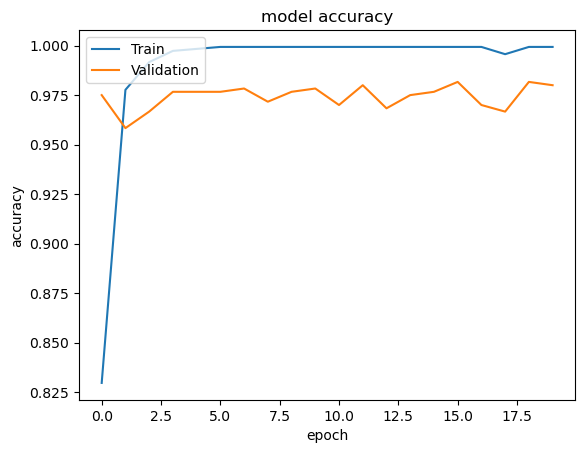

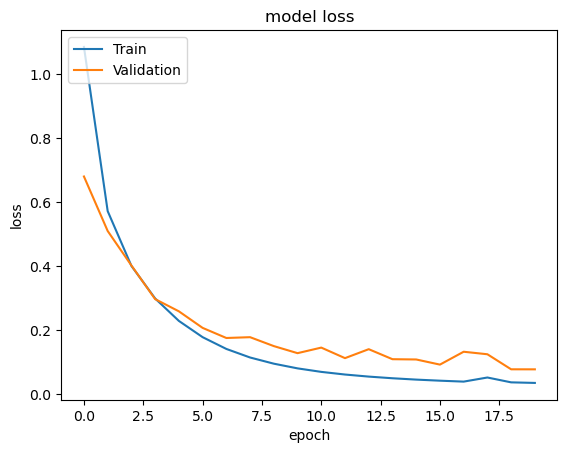

In [16]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [17]:
wav_file = "OnlineMonitor/Audio_labelled/source/test_audio2.wav"
wav = preprocess_wav(wav_file)
cont_embeds, wav_splits = embed_utterance(wav, return_partials=True, rate=16)

In [18]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import librosa.display


def wav_to_img(cont_embeds, img_path):
  for i, mel in enumerate(cont_embeds):

    dpi = 80
    magic_height = 300
    w = 192
    h = 192
    #extract audio features

    #Save the melspectrogram 
    fig = plt.Figure()
    fig.set_size_inches(magic_height*w/(h*dpi), magic_height/dpi)
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(111)
    #Control the margins 
    left = 0.005
    bottom = 0.005 
    width = 0.99
    height = 0.99
    ax = fig.add_axes([left, bottom, width, height])
    ax.set(frame_on=False)
    p = librosa.display.specshow(mel, sr=sampling_rate, hop_length=int(sampling_rate * mel_window_step / 1000), ax = ax);
    fig.savefig(img_path+"_"+str(i)+".png", dpi = 51.4)

In [19]:
model.save("OnlineMonitor/Audio_labelled/saved_models/cnnmodel.hdf5")

In [20]:
os.makedirs("OnlineMonitor/Audio_data/test")

In [21]:
wav_to_img(cont_embeds,"OnlineMonitor/Audio_data/test/")

In [22]:
'''
Function to sort files into alphanumeric ascending order
'''
def alphaNumOrder(string):
    return ''.join([format(int(x), '05d') if x.isdigit() else x for x in re.split(r'(\d+)', string)])

In [23]:
lb.classes_

array(['MV', 'NV', 'SV'], dtype='<U2')

In [24]:
import pandas as pd
df_bars = pd.DataFrame(columns=['index', 'time', 'class', 'color'])
index = 0
'''
set classes for the final data frame to plot values on bar chart
@param df_bars
@param index
@param time slice
@param classid
@param color
'''
def set_df_values(df_bars, index, time, classid, color):
    df_bars.loc[index, 'index'] = index
    df_bars.loc[index, 'time'] = time
    df_bars.loc[index, 'class'] = classid
    df_bars.loc[index, 'color'] = color

In [25]:
import glob,re
files = glob.glob(os.path.join("OnlineMonitor","Audio_data","test","*.png"))
files.sort(key=alphaNumOrder)
similarity_df = {}
label = []
label_index = []
score_MV = []
score_NV = []
score_SV = []
print(lb.classes_)
for key,file in enumerate(files):
  img = cv2.imread(file)
  img = img.reshape(-1,1,192,192,3)
  pred = model.predict(img, verbose=0)
  print(pred[0])
  voice = np.argmax(pred)
  #print(voice)
  similarity_df[str(key)+"_"+lb.classes_[voice]] = pred[0][voice]
  label.append(lb.classes_[voice])
  label_index.append(np.argmax(pred))
  score_MV.append(pred[0][0])
  score_NV.append(pred[0][1])
  score_SV.append(pred[0][2])
  result = voice
  #predict single voice
  if result == 2:
      set_df_values(df_bars, index, 10, "SV", "blue")
      
  #predict multiple voice    
  elif result == 1:
      set_df_values(df_bars, index, 10, "NV", "orange")
  #predict no voice
  elif result == 0:
      set_df_values(df_bars, index, 10, "MV", "green")
  index+=10
  # break

['MV' 'NV' 'SV']
[0.00251226 0.00810007 0.98938763]
[0.00508511 0.03072814 0.9641868 ]
[0.00205699 0.00506265 0.9928804 ]
[0.00390535 0.02450078 0.97159386]
[0.00308073 0.01590949 0.9810098 ]
[0.00238483 0.0096061  0.9880091 ]
[0.00203292 0.00648004 0.991487  ]
[0.0046675  0.04240026 0.95293224]
[0.01278702 0.3826556  0.60455734]
[0.01024217 0.19180058 0.79795724]
[0.00795544 0.09552696 0.89651763]
[0.00405447 0.0247666  0.971179  ]
[0.00380615 0.02505643 0.9711374 ]
[0.00426038 0.0295707  0.96616894]
[0.00477858 0.03710352 0.9581179 ]
[0.00432339 0.02747996 0.9681967 ]
[0.00260287 0.00969744 0.98769975]
[0.00158883 0.00312714 0.995284  ]
[0.00159911 0.00314485 0.995256  ]
[0.00141263 0.00234282 0.99624455]
[0.0013771  0.00219584 0.9964271 ]
[0.00140946 0.00241181 0.99617875]
[0.00145529 0.00267477 0.99586993]
[0.00138924 0.00227836 0.99633247]
[0.00135548 0.00206663 0.9965779 ]
[0.0013015  0.00185938 0.99683917]
[0.00127236 0.00168226 0.99704534]
[0.00132188 0.00189237 0.99678576]
[0.

[0.0029055  0.9882973  0.00879717]
[0.00364236 0.98029476 0.01606278]
[0.00453158 0.96416646 0.03130196]
[0.01098607 0.32653335 0.6624806 ]
[0.0073251  0.11293321 0.87974167]
[0.00970871 0.27401277 0.71627855]
[0.00853927 0.14577717 0.8456835 ]
[0.00352861 0.02379488 0.97267646]
[0.00231669 0.00911135 0.9885719 ]
[0.00230228 0.00863576 0.9890619 ]
[0.00239664 0.00928448 0.9883189 ]
[0.00293542 0.01508443 0.9819802 ]
[0.00323282 0.019004   0.97776324]
[0.00282679 0.01370905 0.9834642 ]
[0.00300534 0.01508814 0.98190653]
[0.00247738 0.00994617 0.9875765 ]
[0.00313477 0.01899721 0.9778681 ]
[0.00387435 0.03055452 0.96557117]
[0.0036621  0.02580087 0.97053707]
[0.00282228 0.01377186 0.9834058 ]
[0.00180438 0.00442308 0.99377257]
[0.00150147 0.00287173 0.9956268 ]
[0.00141888 0.00250719 0.99607396]
[0.00135569 0.00223146 0.9964128 ]
[0.00172846 0.00432587 0.99394566]
[0.00192219 0.00508237 0.99299544]
[0.00391729 0.02682615 0.9692565 ]
[0.00673669 0.0833509  0.9099124 ]
[0.01339984 0.571341

[0.00184226 0.00251236 0.9956454 ]
[0.00161176 0.00193924 0.996449  ]
[0.00222072 0.00353947 0.9942398 ]
[0.00127788 0.00171861 0.9970035 ]
[0.00140416 0.00203433 0.99656147]
[0.00128523 0.00184857 0.99686617]
[0.0012199  0.00155697 0.99722314]
[0.00122936 0.0016011  0.99716955]
[0.00125343 0.00171519 0.99703133]
[0.00131012 0.00190084 0.9967891 ]
[0.00166897 0.00345356 0.9948775 ]
[0.00343189 0.01944739 0.97712076]
[0.00490271 0.04733324 0.947764  ]
[0.01102342 0.46333018 0.5256464 ]
[0.00820335 0.87722087 0.1145758 ]
[0.00965171 0.8315305  0.15881772]
[0.01209564 0.5786526  0.40925172]
[0.01094099 0.31082356 0.6782355 ]
[0.01007992 0.23324512 0.756675  ]
[0.01010295 0.23888816 0.7510089 ]
[0.01169381 0.5418272  0.44647896]
[0.0103948  0.8227778  0.16682743]
[0.01136302 0.76574    0.222897  ]
[0.01246467 0.65342706 0.33410817]
[0.0130177  0.6470862  0.33989608]
[0.00950849 0.16061538 0.8298761 ]
[0.0093736  0.16202895 0.8285975 ]
[0.0124613 0.6374181 0.3501207]
[0.00637723 0.94747955 

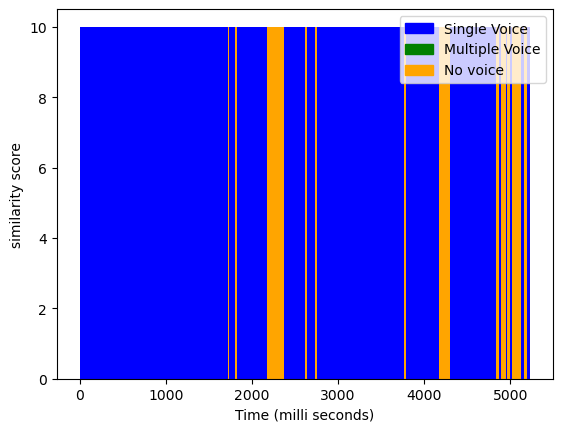

In [26]:
xx=df_bars.iloc[:, 0].values.tolist()
yy =np.array(df_bars.iloc[:, 1].values.tolist())
plt.bar(xx,yy,width=10, color=df_bars.iloc[:, 3].values.tolist())
plt.xlabel('Time (milli seconds)')
plt.ylabel("similarity score")
#plt.title('Class predictions for file ' + audio_test.split("/")[-1])

colors = {'Single Voice':'blue', 'Multiple Voice':'green', 'No voice':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

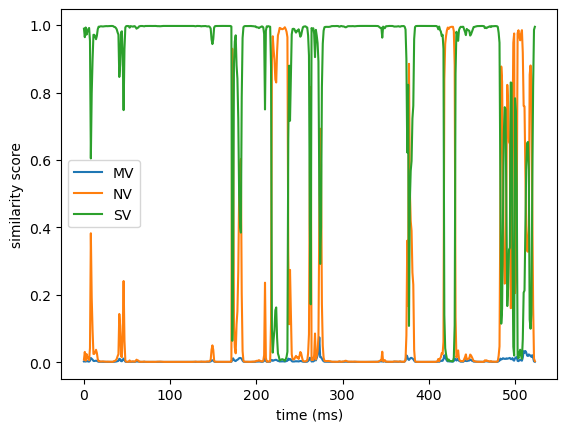

In [27]:
plt.plot(score_MV, label = "MV")
plt.plot(score_NV, label = "NV")
plt.plot(score_SV, label = "SV")
plt.xlabel('time (ms)')
plt.ylabel('similarity score')
plt.legend()
plt.show()